# Step 5 - Model Training

Split the data into training and test sets, ensuring the test set reflects the present year's data.

Train multiple predictive models on the original dataset, without applying PCA or SMOTE techniques initially. 

The models to be trained include:
- K-Nearest Neighbors (KNN) Classifier
- Random Forest

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## 5.0 - Load the Data

In [32]:
previous_scaled = pd.read_csv('../data/05_previous_years_scaled.csv')
present_scaled = pd.read_csv('../data/06_present_year_scaled.csv')

## 5.1 - Model Centric Approach

Apply the ML models without use any PCA or SMOTE technique at first.

### 5.1.1 - Train and Test Split

Since we have the instruction fir the executive board that 

> The final results that will be presented need to be evaluated against air_system_present_year.csv. 

The *train* and *test* split is easily defined as:

- **Training Data:** We will use the `air_system_previous_years.csv` to train the machine learning models.

- **Testing Data:** We will evaluate the trained models using `air_system_present_year.csv`.

In [33]:
# Separate target and features for training data
y_train = previous_scaled['class']
X_train = previous_scaled.drop('class', axis=1)

# Separate target and features for test data
y_test = present_scaled['class']
X_test = present_scaled.drop('class', axis=1)

print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Training features shape: (60000, 170)
Training target shape: (60000,)
Test features shape: (16000, 170)
Test target shape: (16000,)


### 5.1.2 - KNN Classifier

In [34]:
# Fit the data on the classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.86      0.52      0.65       375

    accuracy                           0.99     16000
   macro avg       0.93      0.76      0.82     16000
weighted avg       0.99      0.99      0.99     16000



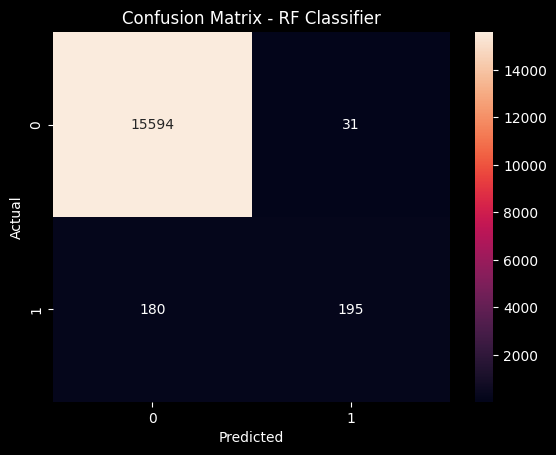

In [35]:
# Calculate the confusion matrix
def confmatrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)

    # Get unique class labels from y_test
    classes = np.unique(y_test)

    # Create a heatmap using seaborn
    plt.style.use("dark_background")
    sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

confmatrix(y_test, y_pred_knn, title = "Confusion Matrix - RF Classifier")


**Performance Analysis**

- **Recall:** The recall for the minority class (1) is quite low (0.52), indicating that the model is missing many of the positive cases.

### 5.1.3 - Random Forest

In [39]:
# Fit the data on the classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.96      0.64      0.77       375

    accuracy                           0.99     16000
   macro avg       0.98      0.82      0.88     16000
weighted avg       0.99      0.99      0.99     16000



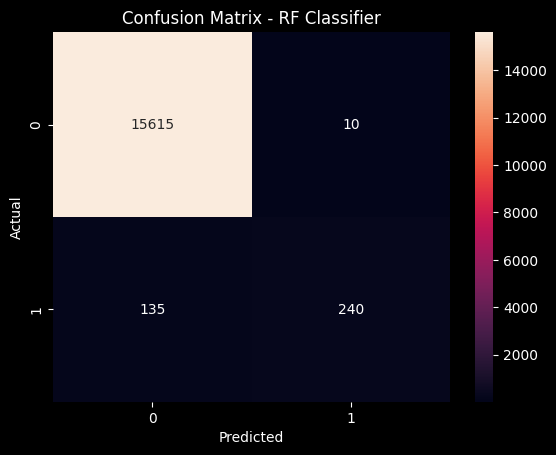

In [40]:
confmatrix(y_test, y_pred_rf, title = "Confusion Matrix - RF Classifier")

**Performance Analysis**

- **Recall:** The recall for the minority class (1) is quite low (0.64), indicating that the model is missing many of the positive cases.
- **Accuracy:** Overall accuracy is high (0.99), but this can be misleading in cases of class imbalance.

This is a tipycal problem of a imbalanced dataset, the first solution is to address class imbalance and perform the feature selection:

- **Resampling Techniques:**
    - **Oversampling:** Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority class.
    - **Undersampling:** Reduce the number of samples in the majority class to balance the class distribution.

- **Feature Selection:** Revisit feature selection and engineering to ensure that the most relevant features are used.

Before this, we also perform a basic HPO on the RF Classifier to visualize that a direct Model Centric approach will not be enough:

### 5.1.4 - Hyperparameter Tunning

Perform extensive hyperparameter tuning using techniques like Grid Search or Random Search to find the optimal settings for the models.

In [28]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(20, 200),       # Number of trees in the forest
    'max_depth': randint(1, 40),            # Maximum depth of each tree
    'min_samples_split': randint(2, 20),    # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]              # Whether bootstrap samples are used when building trees
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier()

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,                       # Number of different combinations to try
    cv=5,                           # Number of cross-validation folds
    verbose=2,                      # Verbosity level
    random_state=42,                # For reproducibility
    n_jobs=-1                       # Use all available cores
)

# Fit RandomizedSearchCV to the training data
rand_search.fit(X_train, y_train)
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  48.1s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  48.1s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  49.4s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  49.6s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  50.3s
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time=  58.6s
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time=  58.5s
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time= 1.0min
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1

In [ ]:
# Generate predictions with the best model
y_pred_best_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.92      0.62      0.75       375

    accuracy                           0.99     16000
   macro avg       0.96      0.81      0.87     16000
weighted avg       0.99      0.99      0.99     16000



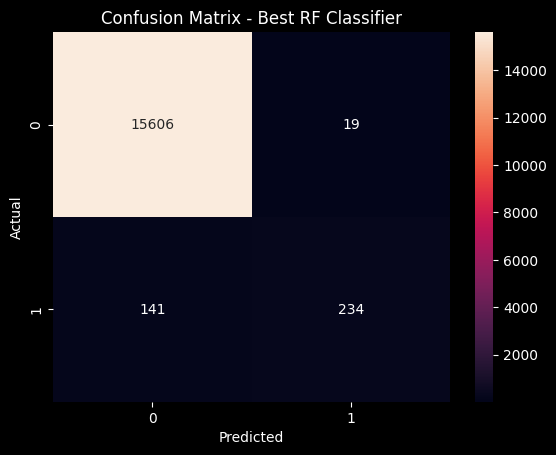

In [ ]:
confmatrix(y_test, y_pred_best_rf, title = "Confusion Matrix - Best RF Classifier")

Notice, the poor performance still remains on the model.

## 5.2 - Data Centric Approach

Now, in the second part of this notebook, we will apply the models after performing some data-centric analyses, such as addressing class imbalance and performing feature selection.